In [1811]:
import pandas as pd
import numpy as np
# Sets and Parameters 1
scale = 1
n = 80
m = 8
r = 3
set_I = range(1,n+1)
set_K = range(1,m+1)
set_T = range(1,r+1)
c = {k: 4 for k in set_K}
delta = {k: 3 for k in set_K}
gamma = {k: 2 for k in set_K}
e = {k: 0.1 for k in set_K}
P_it = [];alpha_i = [];CS_coor=[];CS_coor=[]
# lambda_ikt = pd.read_table("./lambda.csv",sep=",")
# P_it = pd.read_table("./P.csv",sep=",")
# alpha_i = pd.read_table("./alpha.csv",sep=",")
# CS_coor = pd.read_table("./CS candidates coordinates.csv",sep=",")
# Users_coor = pd.read_table("./Users coordinates.csv",sep=",")
def import_data(n,m):
    global P_it,alpha_i,CS_coor,Users_coor
    P_it = pd.read_table("./Data/P_{0}_{1}.csv".format(n,m),sep=",")
    alpha_i = pd.read_table("./Data/alpha_{0}_{1}.csv".format(n,m),sep=",")
    CS_coor = pd.read_table("./Data/CS candidates coordinates_{0}_{1}.csv".format(n,m),sep=",")
    Users_coor = pd.read_table("./Data/Users coordinates_{0}_{1}.csv".format(n,m),sep=",")
import_data(n,m)
P = {(i,t): P_it.iloc[i-1][t-1] for i in set_I for t in set_T} 
# lambda_ = {(j%n+1,k,j//n+1): lambda_ikt.iloc[j][k-1] for j in range(n*r) for k in set_K}
alpha = alpha_i.values.flatten()
cord_x = np.zeros([r,n])                    
cord_y = np.zeros([r,n])
for i in range(n):
    for j in range(r):
        cord_x[j][i] = np.array(Users_coor.iloc[i][2*j])
        cord_y[j][i] = np.array(Users_coor.iloc[i][2*j+1])
cord_x_K = np.array(CS_coor["x"])
cord_y_K = np.array(CS_coor["y"])
max_beta = len(c)*(list(c.values())[0]*list(delta.values())[0]) # maximum budget

<Figure size 432x288 with 0 Axes>

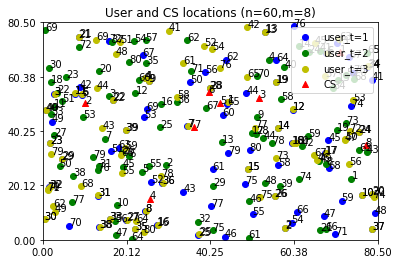

In [1812]:
import os
import matplotlib.pyplot as plt
# location initialisation

# cord_x = np.zeros([r,n])                    # EV users locations at each time period
# cord_y = np.zeros([r,n])
# cord_x_K = np.array(50*n*np.random.rand(m))  # Charging station
# cord_y_K = np.array(50*n*np.random.rand(m))
# for t in range(r):
#     cord_x[t] = np.array(50*n*np.random.rand(n))
#     cord_y[t] = np.array(50*n*np.random.rand(n))

plt.figure()
fig,ax=plt.subplots()
plt.xlim(xmin = 0, xmax = (scale*n)+0.5)                  
plt.ylim(ymin = 0, ymax = (scale*n)+0.5)                  
plt.xticks(np.linspace(0, (scale*n)+0.5, 5))
plt.yticks(np.linspace(0, (scale*n)+0.5, 5))
# plt.grid()
plt.title('User and CS locations (n=60,m=8)')
color_lst = ['b','g','y','m','c']
label_lst = ['user_t=1','user_t=2','user_t=3','user_t=4','user_t=5']
for t in range(r):
    plt.scatter(cord_x[t], cord_y[t], marker = 'o', color=color_lst[t], label=label_lst[t])
    for i,txt in enumerate(np.arange(1,n+1)):
        ax.annotate(txt,(cord_x[t][i],cord_y[t][i]))
plt.scatter(cord_x_K, cord_y_K, marker = '^', color='r', label='CS')
for i,txt in enumerate(np.arange(1,m+1)):
    ax.annotate(txt,(cord_x_K[i],cord_y_K[i]))
ax.legend(loc='upper right')
path = os.getcwd()              
fileName = "User and CS locations 60 8"
filePath = path + "\\" + fileName + ".png"
plt.savefig(filePath, dpi=1500,facecolor='w')  

In [1813]:
# Sets and Parameters 2 : lambda
# Euclidean distance between users and stations
dist = np.zeros([r,m,n])
for t in range(r):
    for k in range(m):
        for i in range(n):
            dist[t][k][i] = np.array(np.sqrt((cord_x[t][i]-cord_x_K[k])**2 + (cord_y[t][i]-cord_y_K[k])**2))
# Normalization
normal_dist = np.zeros([r,m,n])
lambda_ = {}
for t in range(r):
    for k in range(m):
        for i in range(n):
#             normal_dist[t][k][i] = (dist[t][k][i]-min(dist[t][k]))/(max(dist[t][k])-min(dist[t][k]))
            normal_dist[t][k][i] = dist[t][k][i]/dist.max()
            lambda_[(i+1,k+1,t+1)] = round(normal_dist[t][k][i],2)
# number of zones (here set 0-1)

In [1814]:
# Sets and Parameters 3 : v -- the preference list assume length s = 2 
from heapq import nsmallest
s = 3
set_S = range(1,s+1)
comb_dict = {}
comb = {}
v = {}
for i in range(n+1):
    comb_dict[i-1]=nsmallest(s, comb, key = comb.get) # select first s smallest elements in combination
    comb = {}
    if i==n:
        break
    for k in set_K:
        for t in set_T:
            comb[(k,t)] = alpha[i]*lambda_[(i+1,k,t)]+(1-alpha[i])*P[(i+1,t)]/max(P.values())
del comb_dict[-1]      # preference lists
for t in set_T:
    for k in set_K:
        for i in range(n):
            for l in range(s):
                v[(i+1,l+1,k,t)] = 1 if (k,t) == comb_dict[i][l] else 0 

In [1815]:
import docplex.mp.model as cpx
opt_model = cpx.Model(name="MIP Model")

In [1816]:
import math
# if x is Continuous
p  = {(k,t): opt_model.continuous_var(name="p_{0}_{1}".format(k,t)) for k in set_K for t in set_T}

rou = {(i): opt_model.continuous_var(lb= -math.inf, name="rou_{0}".format(i)) for i in set_I}

phi = {(i,k,t): opt_model.continuous_var(name="phi_{0}_{1}_{2}".format(i,k,t)) for i in set_I for k in set_K for t in set_T}

pi = {(k,t): opt_model.continuous_var(name="pi_{0}_{1}".format(k,t)) for k in set_K for t in set_T}

# if x is Binary
x  = {(i,k,t): opt_model.binary_var(name="x_{0}_{1}_{2}".format(i,k,t)) for i in set_I for k in set_K for t in set_T}

w  = {(i,l,k,t): opt_model.binary_var(name="w_{0}_{1}_{2}_{3}".format(i,l,k,t)) for i in set_I for l in set_S for k in set_K for t in set_T}

z = {(i): opt_model.binary_var(name="z_{0}".format(i)) for i in set_I}

xi = {(k,t): opt_model.binary_var(name="xi_{0}_{1}".format(k,t)) for k in set_K for t in set_T}

# if x is Integer
y  = {(k): opt_model.integer_var(ub= delta[k],name="y_{0}".format(k)) for k in set_K}

In [1817]:
# budget conostraint? 

M_0 = 100 # M_0 >> max(P)
eplison = 1e-5 # small value number
M_1 = 100000
M_2 = 100000
M_3 = 100000
M_4 = 100000

# Updating predefining preference list based on cost

constraint_11 = {(i,t,k,l) : opt_model.add_constraint(ct= v[i,l,k,t]*eplison + (v[i,l,k,t]*(P[i,t]-p[k,t]))/M_0 <= w[i,l,k,t],ctname="constraint11_{0}_{1}_{2}_{3}".format(i,t,k,l))
    for i in set_I for t in set_T for k in set_K for l in set_S}

constraint_12 = {(i,t,k,l) : opt_model.add_constraint(ct= v[i,l,k,t] + (v[i,l,k,t]*(P[i,t]-p[k,t]))/M_0 >= w[i,l,k,t],ctname="constraint12_{0}_{1}_{2}_{3}".format(i,t,k,l))
    for i in set_I for t in set_T for k in set_K for l in set_S}

# Reinforcing opt-in / out

constraint_21 = {(i) : opt_model.add_constraint(ct= opt_model.sum(w[i,l,k,t] for k in set_K for l in set_S for t in set_T)/s <= z[i],ctname="constraint21_{0}".format(i))
    for i in set_I}

constraint_22 = {(i) : opt_model.add_constraint(ct= opt_model.sum(w[i,l,k,t] for k in set_K for l in set_S for t in set_T) >= z[i],ctname="constraint22_{0}".format(i))
    for i in set_I}

# Lagrangian, KKT of EV user

constraint_31 = {(i,k,t) : opt_model.add_constraint(ct= lambda_[i,k,t] + opt_model.sum(l * w[i,l,k,t] for l in set_S) + pi[k,t] + rou[i] + phi[i,k,t] >= 0,ctname="constraint31_{0}_{1}_{2}".format(i,k,t))
    for i in set_I for k in set_K for t in set_T}

constraint_32 = {(i,k,t) : opt_model.add_constraint(ct= lambda_[i,k,t] + opt_model.sum(l * w[i,l,k,t] for l in set_S) + pi[k,t] + rou[i] + phi[i,k,t] <= M_1*(1 - x[i,k,t]),ctname="constraint32_{0}_{1}_{2}".format(i,k,t))
    for i in set_I for k in set_K for t in set_T}

# usage capacity limit

constraint_41 = {(k,t) : opt_model.add_constraint(ct= opt_model.sum(x[i,k,t] for i in set_I) <= gamma[k]*y[k],ctname="constraint41_{0}_{1}".format(k,t))
    for k in set_K for t in set_T}

constraint_42 = {(k,t) : opt_model.add_constraint(ct= gamma[k]*y[k] - opt_model.sum(x[i,k,t] for i in set_I) <= M_2*(1 - xi[k,t])  ,ctname="constraint42_{0}_{1}".format(k,t))
    for k in set_K for t in set_T}

constraint_43 = {(k,t) : opt_model.add_constraint(ct= pi[k,t] <= M_3 * xi[k,t],ctname="constraint43_{0}_{1}".format(k,t))
    for k in set_K for t in set_T}

# Ensure EV users to select at most only the CS from their preference list  # Big-M relaxation

constraint_5 = {(i) : opt_model.add_constraint(ct= opt_model.sum(x[i,k,t] for t in set_T for k in set_K) == z[i],ctname="constraint5_{0}".format(i))
    for i in set_I}

constraint_61 = {(i,t,k) : opt_model.add_constraint(ct= x[i,k,t] <= opt_model.sum(w[i,l,k,t] for l in set_S),ctname="constraint61_{0}_{1}_{2}".format(i,t,k))
    for i in set_I for t in set_T for k in set_K}

constraint_62 = {(i,t,k) : opt_model.add_constraint(ct= phi[i,k,t] <= M_4*(1 + x[i,k,t] - opt_model.sum(w[i,l,k,t] for l in set_S)),ctname="constraint62_{0}_{1}_{2}".format(i,t,k))
    for i in set_I for t in set_T for k in set_K}

# Budget constraint

constraint_7 = opt_model.add_constraint(ct= opt_model.sum(c[k]*y[k] for k in set_K) <= max_beta*0.5,ctname="constraint_budget")

# Extra constraint for testing : coupling constraint and set upper bound for price
# constraint_7 = {(k): opt_model.add_constraint(ct= y[k]- opt_model.sum(x[i,k,t] for i in set_I for t in set_T) <= 0, ctname="constraint_7_{0}".format(k)) for k in set_K}

# constraint_8 = {(k,t): opt_model.add_constraint(ct= p[k,t] - opt_model.sum(x[i,k,t] for i in set_I) <= 0, ctname="constraint_8_{0}_{1}".format(k,t)) for k in set_K for t in set_T}

In [1818]:
# define objective
objective = opt_model.sum(p[k,t]*x[i,k,t] for i in set_I for k in set_K for t in set_T) - opt_model.sum(c[k]*y[k] for k in set_K) - opt_model.sum(e[k]*x[i,k,t] for i in set_I for k in set_K for t in set_T)

In [1819]:
#add into model
# for maximization
opt_model.maximize(objective)
# for minimization
# opt_model.minimize(objective)

In [1820]:
sol = opt_model.solve(log_output=True)

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.57 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 14400 rows and 7200 columns.
MIP Presolve added 480 rows and 240 columns.
MIP Presolve modified 539 coefficients.
Reduced MIP has 5593 rows, 2880 columns, and 16928 nonzeros.
Reduced MIP has 584 binaries, 8 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (20.32 ticks)
Probing fixed 0 vars, tightened 245 bounds.
Probing time = 0.01 sec. (3.20 ticks)
Tried aggregator 2 times.
Detecting symmetries...
MIP Presolve eliminated 538 rows and 196 columns.
MIP Presolve modified 240 coefficients.
Aggregator did 1 substitutions.
Reduced MIP has 5054 rows, 2683 columns, and 15818 nonzeros.
Reduced MIP has 398 binaries, 8 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (16.52 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.0

  13117  5861      194.2338   142      182.9000      203.5399  7018436   11.28%
  13459  6161      195.7447   172      182.9000      203.5006  7281626   11.26%
Elapsed time = 81.58 sec. (50398.29 ticks, tree = 9.28 MB, solutions = 2)
  13778  6497      189.1326   149      182.9000      203.3756  7533905   11.19%
  14087  6538      198.7264   163      182.9000      203.3170  7585407   11.16%
  14439  6759        cutoff            182.9000      203.2495  7777962   11.13%
  14803  7131      199.3002   186      182.9000      203.2495  8125277   11.13%
  15133  7280        cutoff            182.9000      203.1987  8241955   11.10%
  15386  7319      188.4381   115      182.9000      203.1311  8287773   11.06%
  15731  7789      193.8437   174      182.9000      203.0875  8667874   11.04%
  15991  7962      193.9501   120      182.9000      203.0317  8813808   11.01%
  16262  7990      190.5174   125      182.9000      202.9735  8851834   10.98%
  16552  8304      199.9075   148      182.900

In [1821]:
sol.get_objective_value()

200.80000000000035

In [1822]:
opt_model.solve_details.time

154.76500000013039

In [1823]:
wk = sol.get_value_dict(w)
xk = sol.get_value_dict(x)
zk = sol.get_value_dict(z)
pk = sol.get_value_dict(p)
yk = sol.get_value_dict(y)
print(len(wk),len(xk),len(zk),len(pk),len(yk))

5760 1920 80 24 8


In [1824]:
import pandas as pd
opt_df_x = pd.DataFrame.from_dict(x, orient="index", 
                                columns = ["variable_object"])
opt_df_x.index = pd.MultiIndex.from_tuples(opt_df_x.index, 
                               names=["i", "k", "t"])
opt_df_x.reset_index(inplace=True)

opt_df_x["solution_value"] = opt_df_x["variable_object"].apply(lambda item: item.solution_value)
    
opt_df_x.drop(columns=["variable_object"], inplace=True)
opt_df_x.to_csv("./optimization_solution_for_x.csv")

In [1825]:
opt_df_p = pd.DataFrame.from_dict(p, orient="index", 
                                columns = ["variable_object"])
opt_df_p.index = pd.MultiIndex.from_tuples(opt_df_p.index, 
                               names=["k", "t"])
opt_df_p.reset_index(inplace=True)

# CPLEX
opt_df_p["solution_value"] = opt_df_p["variable_object"].apply(lambda item: item.solution_value)
    
opt_df_p.drop(columns=["variable_object"], inplace=True)
opt_df_p.to_csv("./optimization_solution_for_p.csv")

In [1826]:
opt_df_y = pd.DataFrame.from_dict(y, orient="index", 
                                columns = ["variable_object"])
opt_df_y.index = pd.Index(opt_df_y.index,name="k")
opt_df_y.reset_index(inplace=True)

# CPLEX
opt_df_y["solution_value"] = opt_df_y["variable_object"].apply(lambda item: item.solution_value)
    
opt_df_y.drop(columns=["variable_object"], inplace=True)
opt_df_y.to_csv("./optimization_solution_for_y.csv")

In [1827]:
opt_df_z = pd.DataFrame.from_dict(z, orient="index", 
                                columns = ["variable_object"])
opt_df_z.index = pd.Index(opt_df_z.index,name="i")
opt_df_z.reset_index(inplace=True)

# CPLEX
opt_df_z["solution_value"] = opt_df_z["variable_object"].apply(lambda item: item.solution_value)
    
opt_df_z.drop(columns=["variable_object"], inplace=True)
opt_df_z.to_csv("./optimization_solution_for_z.csv")

In [1828]:
opt_df_w = pd.DataFrame.from_dict(w, orient="index", 
                                columns = ["variable_object"])
opt_df_w.index = pd.MultiIndex.from_tuples(opt_df_w.index, 
                               names=["i", "l", "k", "t"])
opt_df_w.reset_index(inplace=True)

# CPLEX
opt_df_w["solution_value"] = opt_df_w["variable_object"].apply(lambda item: item.solution_value)
    
opt_df_w.drop(columns=["variable_object"], inplace=True)
opt_df_w.to_csv("./optimization_solution_for_w.csv")

In [1829]:
# Active EV Users 
sum(opt_df_z['solution_value'])

72.0

In [1830]:
opt_df_y

,k,solution_value
0,1,1.0
1,2,1.0
2,3,2.0
3,4,2.0
4,5,1.0
5,6,3.0
6,7,1.0
7,8,1.0


In [1831]:
# Active CS
len(np.where(opt_df_y['solution_value']!=0)[0])

8

In [1832]:
# Active CS spots
sum(opt_df_y['solution_value'])

12.0

In [1833]:
# active EV users who got 1st 2nd choices
loc_res = opt_df_x.loc[abs(opt_df_x['solution_value']-1)<=0.1 ,['i','k','t']]
pre_choice = opt_df_w.loc[abs(opt_df_w['solution_value']-1)<=0.1,['i','l','k','t']]
correct_res = pd.merge(loc_res, pre_choice, how='inner', on=['i','k','t'])
first = np.array(correct_res.loc[correct_res['l']==1]['i'])
second = np.array(correct_res.loc[correct_res['l']==2]['i'])
third = np.array(correct_res.loc[correct_res['l']==3]['i'])
print(len(first),len(second),len(third))

18 28 26


<Figure size 432x288 with 0 Axes>

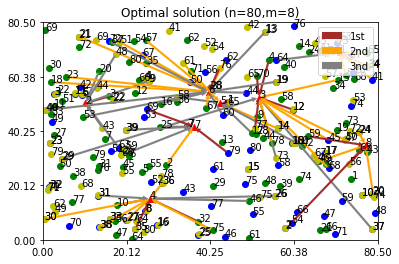

In [1834]:
plt.figure()
fig,ax=plt.subplots()
plt.xlim(xmin = 0, xmax = (scale*n)+0.5)                  
plt.ylim(ymin = 0, ymax = (scale*n)+0.5)                  
plt.xticks(np.linspace(0, (scale*n)+0.5, 5))
plt.yticks(np.linspace(0, (scale*n)+0.5, 5))
# plt.grid()
plt.title('Optimal solution (n=80,m=8)')
color_lst_arrow = ['brown','orange','grey']
label_lst_arrow = ['1st','2nd','3nd']
for i in set_I:
    for k in set_K:
        for t in set_T:
            if i in first and v[i,1,k,t] == 1:
                h1=ax.annotate(text="",xy=(cord_x_K[k-1],cord_y_K[k-1]),xytext=(cord_x[t-1][i-1],cord_y[t-1][i-1]),arrowprops=dict(arrowstyle="simple",color=color_lst_arrow[0],linewidth=0.1),label=label_lst_arrow[0])
            if i in second and v[i,2,k,t] == 1:
                h2=ax.annotate(text="",xy=(cord_x_K[k-1],cord_y_K[k-1]),xytext=(cord_x[t-1][i-1],cord_y[t-1][i-1]),arrowprops=dict(arrowstyle="simple",color=color_lst_arrow[1],linewidth=0.1),label=label_lst_arrow[1])
            if i in third and v[i,3,k,t] == 1:
                h3=ax.annotate(text="",xy=(cord_x_K[k-1],cord_y_K[k-1]),xytext=(cord_x[t-1][i-1],cord_y[t-1][i-1]),arrowprops=dict(arrowstyle="simple",color=color_lst_arrow[2],linewidth=0.1),label=label_lst_arrow[2])

color_lst = ['b','g','y','m','c']
label_lst = ['user_t=1','user_t=2','user_t=3','user_t=4','user_t=5']
for t in range(r):
    ax.scatter(cord_x[t], cord_y[t], marker = 'o', color=color_lst[t])
    for i,txt in enumerate(np.arange(1,n+1)):
        ax.annotate(txt,(cord_x[t][i],cord_y[t][i]))
ax.scatter(cord_x_K, cord_y_K, marker = '^', color='r')
for i,txt in enumerate(np.arange(1,m+1)):
    ax.annotate(txt,(cord_x_K[i],cord_y_K[i]))

ax.legend([h1.arrow_patch,h2.arrow_patch,h3.arrow_patch],tuple(label_lst_arrow),loc='upper right')
path = os.getcwd()              
fileName = "Optimal solution n=80,m=8"
filePath = path + "\\" + fileName + ".png"
plt.savefig(filePath, dpi=1500,facecolor='w') 

In [1835]:
opt_df_p

,k,t,solution_value
0,1,1,5.0
1,1,2,3.0
2,1,3,3.0
3,2,1,4.0
4,2,2,4.0
5,2,3,4.0
6,3,1,3.0
7,3,2,3.0
8,3,3,3.0
9,4,1,4.0


In [1836]:
wk = sol.get_value_dict(w)
xk = sol.get_value_dict(x)
zk = sol.get_value_dict(z)
pk = sol.get_value_dict(p)
yk = sol.get_value_dict(y)
for i in set_I:
    for l in set_S:
        for k in set_K:
            for t in set_T:
                try:
                    wk[i,l,k,t]
                except KeyError:
                    wk[i,l,k,t]=0
                try:
                    xk[i,k,t]
                except KeyError:
                    xk[i,k,t]=0
                try:
                    zk[i]
                except KeyError:
                    zk[i]=0
                try:
                    yk[k]
                except KeyError:
                    yk[k]=0            
print(len(wk),len(xk),len(zk),len(yk))

5760 1920 80 8


In [1837]:
lower_level=cpx.Model(name="lower_level_obj")
objective_ll = lower_level.sum(
        (lambda_[i, k, t] + lower_level.sum(float(l) * wk[i,l,k,t] for l in set_S)) * xk[i,k,t] for i in set_I for k in
        set_K for t in set_T)
lower_level.maximize(objective_ll)
lower_level.solve(log_output=False).get_objective_value()

165.23999999999995